In [1]:
import equinox as eqx
import jax
import optax
from jaxtyping import Array, Float, UInt
from tqdm.notebook import trange

from deep_sets_jax.dataset import Dataset
from deep_sets_jax.model import DeepSets, loss

In [2]:
dataset = Dataset.download_archive()
dataset

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Dataset(
  x_train=u8[60000,28,28],
  x_test=u8[10000,28,28],
  y_train=u8[60000],
  y_test=u8[10000]
)

In [3]:
key = jax.random.PRNGKey(1234)
key_model, key_train, key_test = jax.random.split(key, 3)
model = DeepSets(key_model)

In [4]:
opt = optax.adam(learning_rate=1)
opt_state = opt.init(eqx.filter(model, eqx.is_array))
steps = 10000
print_every = 1000
num_test_samples = 1000

test_samples = [
    (x_test, y_test)
    for _, (x_test, y_test) in zip(
        range(num_test_samples), dataset.sample_test(key_test), strict=False
    )
]


@eqx.filter_jit
def make_step(
    model: DeepSets,
    opt_state: optax.OptState,
    x: Float[Array, "num_images 1 28 28"],
    y: UInt[Array, " "],
) -> tuple[DeepSets, optax.OptState, float]:
    """
    Perform one (gradient) step using the gradient of the loss function, and the current optimization state.

    Args:
        model: The Deep Sets model.
        opt_state: The current optimization state.
        x: The input image(s).
        y: The desired output.
    """
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


with trange(steps, desc="", unit=" steps", leave=False) as bar:
    for step, (x_train, y_train) in zip(
        bar, dataset.sample_train(key_train), strict=False
    ):
        model, opt_state, train_loss = make_step(model, opt_state, x_train, y_train)
        if (step % print_every) == 0 or (step == steps - 1):
            test_loss = 0
            for x_test, y_test in test_samples:
                test_loss += loss(model, x_test, y_test)
            test_loss /= num_test_samples

            bar.set_description(f"train_loss = {float(train_loss):.1f}, test_loss = {float(test_loss):.1f}")

  0%|          | 0/10000 [00:00<?, ? steps/s]

In [5]:
test_samples_iter = dataset.sample_test(key_test)

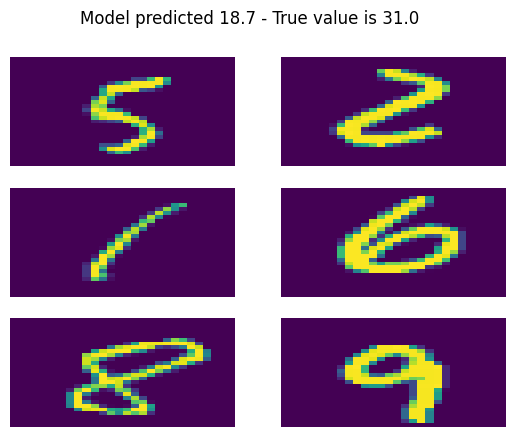

In [6]:
x_test, y_test = next(test_samples_iter)  # Each time this cell is run, a new sample is used.

with jax.disable_jit():
    loss(model, x_test, y_test, plot=True)